<a href="https://colab.research.google.com/github/tlamadon/pygrpfe/blob/main/docs-src/notebooks/gfe_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discretizing Unobserved Heterogeneity: A Step-by-Step Example

Welcome to the example on using the estimator proposed in [Bonhomme, Lamadon and Manresa (2021)](https://www.econometricsociety.org/system/files/15238-5.pdf). This notebook provides the code to reproduce the first example of the paper. 

We will simulate from a model and estimate the main parameters by grouping individuals first.

You can run the code in this notebook by selecting `Runtime > Run all` in the menu bar.



In [ ]:
%%capture
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from statsmodels.discrete.discrete_model import Probit
import patsy
import matplotlib.pylab as plt
import tqdm
import itertools

ax = np.newaxis

The following command makes sure the pygfe package is installed. It provides a small set of helper functions. You can view it online at [pygrpfe](https://github.com/tlamadon/pygrpfe). Here we install it using a shell pip command:

In [ ]:
%%capture
!pip install pygrpfe
import pygrpfe as gfe

# A simple model of wage and participation

\begin{align*}
Y^*_{it} & = \alpha_i + \epsilon_{it} \\
D_{it} &= 1\big[ u(\alpha_i) \geq c(D_{it-1}) + V_{it}  \big] \\
Y_{it} &= D_{it} Y^*_{it} \\
\end{align*}

where we use 

$$u(\alpha) = \frac{e^{(1-\gamma) \alpha } -1}{1-\gamma}$$

and use as initial conditions $D_{i1} = 1\big[ u(\alpha_i) \geq c(1) + V_{i1}  \big]$.

In [ ]:
def dgp_simulate(ni,nt,gamma=2.0,eps_sd=1.0):
    """ simulates according to the model """
    alpha = np.random.normal(size=(ni))
    eps   = np.random.normal(size=(ni,nt))
    v     = np.random.normal(size=(ni,nt))
    
    # non-censored outcome
    W = alpha[:,ax] + eps*eps_sd
    
    # utility
    U = (np.exp( alpha * (1-gamma)) - 1)/(1-gamma)
    U = U - U.mean()
    
    # costs
    C1 = -1; C0=0;
    
    # binary decision
    Y = np.ones((ni,nt))
    Y[:,0] = U.squeeze() > C1 + v[:,0]
    for t in range(1,nt): 
        Y[:,t] = U > C1*Y[:,t-1] + C0*(1-Y[:,t-1]) + v[:,t]
    W =  W * Y
        
    return(W,Y)

# Simulating and estimating the model

We show the steps to estimating the model. 

We simulate from the DGP we have defined.

In [ ]:
ni = 1000
nt = 20
Y,D = dgp_simulate(ni,nt,2.0)

## Step 1: grouping observations

We group individuals based on their outcomes. We consider as moments the average value of $DY$ and the average value of $D$. We give our gfe function the $t$-specific values so that it can compute the within individual variation. This is a measure used to pick the number of groups.

The `group` function chooses the number of groups based on the rule described in the paper. 

In [ ]:
# we create the moments
# this has dimension ni x nt x nm 
M_itm = np.stack([Y,D],axis=2)

# we use our sugar function to get the groups
G_i,_  = gfe.group(M_itm)

print("Number of groups = {:d}".format(G_i.max()))

Number of groups = 17


We can plot the grouping:

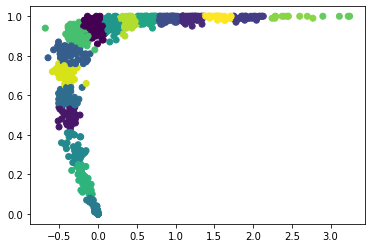

In [ ]:
dd = pd.DataFrame({'Y':Y.mean(1),'G':G_i,'D':D.mean(1)})
plt.scatter(dd.Y,dd.D,c=dd.G*1.0)
plt.show()

## Step 2: Estimate the likelihood model with group specific parameters

In the model we proposed, this second step is a probit. We can then directly use the python probit routine with group dummies.

In [ ]:
ni,nt = D.shape

# next we minimize using groups as FE
dd = pd.DataFrame({
    'd': D[:,range(1,nt)].flatten(), 
    'dl':D[:,range(nt-1)].flatten(), 
    'gi':np.broadcast_to(G_i[:,ax], (ni,nt-1)).flatten()})

yv,Xv = patsy.dmatrices("d ~ 0 + dl + C(gi)", dd, return_type='matrix')
mod = Probit(dd['d'], Xv)
res = mod.fit(maxiter=2000,method='bfgs') 

print("Estimated cost parameters = {:.3f}".format(res.params[-1]))

Optimization terminated successfully.
         Current function value: 0.218178
         Iterations: 161
         Function evaluations: 162
         Gradient evaluations: 162
Estimated cost parameters = 1.005
